In [211]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

# 1. Загрузка данных

In [212]:
%load_ext sql
%sql sqlite:///Diamonds

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [213]:
db = %sql select * from Diamond
db = db.DataFrame()
db = db.set_index("id")

 * sqlite:///Diamonds
Done.


# 2. Data preproccesing

In [214]:
from sklearn.model_selection import train_test_split 

In [215]:
db[:5]

,carat,cut,color,clarity,depth,table,x,y,z,price
id,,,,,,,,,,
0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


In [216]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40455 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40455 non-null  float64
 1   cut      40455 non-null  object 
 2   color    40455 non-null  object 
 3   clarity  40455 non-null  object 
 4   depth    40455 non-null  float64
 5   table    40455 non-null  float64
 6   x        40455 non-null  float64
 7   y        40455 non-null  float64
 8   z        40455 non-null  float64
 9   price    40455 non-null  float64
dtypes: float64(7), object(3)
memory usage: 3.4+ MB


In [217]:
db.describe()

,carat,depth,table,x,y,z,price
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,0.797576,61.746377,57.451694,5.729163,5.732896,3.537351,7.783822
std,0.475939,1.436796,2.234569,1.125244,1.154799,0.711002,1.016828
min,0.200000,43.000000,44.000000,0.000000,0.000000,0.000000,5.787000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,6.851000
50%,0.700000,61.800000,57.000000,5.690000,5.700000,3.520000,7.780000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.030000,8.581000
max,5.010000,79.000000,95.000000,10.740000,58.900000,31.800000,9.842000


In [218]:
db.describe(include=object)

,cut,color,clarity
count,40455,40455,40455
unique,5,7,8
top,Ideal,G,SI1
freq,16230,8410,9779


In [219]:
db.nunique()

carat       269
cut           5
color         7
clarity       8
depth       179
table       122
x           546
y           544
z           366
price      3512
dtype: int64

In [220]:
Y = db["price"]
X = db.drop(["price"], axis=1)

In [221]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
train_data = x_train.join(y_train)

In [222]:
train_data[:5]

,carat,cut,color,clarity,depth,table,x,y,z,price
id,,,,,,,,,,
28665,0.33,Premium,G,VS1,60.3,58.0,4.52,4.50,2.72,6.681
37184,0.36,Premium,E,VS2,60.3,59.0,4.58,4.64,2.78,6.671
29652,0.90,Very Good,D,SI1,59.5,57.0,6.19,6.34,3.73,8.394
11755,1.12,Premium,J,SI2,60.7,61.0,6.71,6.64,4.05,8.091
6368,0.73,Ideal,G,SI1,60.9,57.0,5.81,5.85,3.55,8.036


/tmp/ipykernel_15008/926737507.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(method='spearman'), annot=True, fmt=".2f")


<AxesSubplot: >

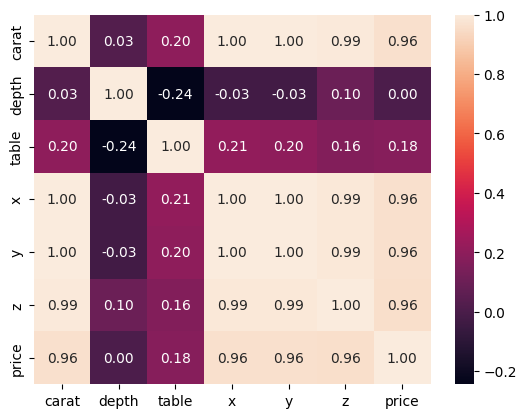

In [223]:
sns.heatmap(train_data.corr(method='spearman'), annot=True, fmt=".2f")

In [224]:
#train_data.drop(["x", "y", "z"], axis=1, inplace=True)

/tmp/ipykernel_15008/926737507.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(method='spearman'), annot=True, fmt=".2f")


<AxesSubplot: >

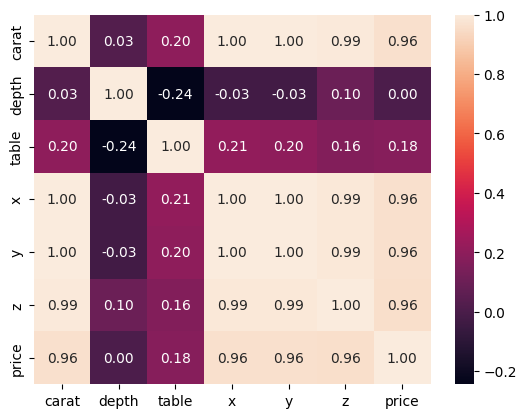

In [225]:
sns.heatmap(train_data.corr(method='spearman'), annot=True, fmt=".2f")

array([[<AxesSubplot: title={'center': 'carat'}>,
        <AxesSubplot: title={'center': 'depth'}>,
        <AxesSubplot: title={'center': 'table'}>],
       [<AxesSubplot: title={'center': 'x'}>,
        <AxesSubplot: title={'center': 'y'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 'price'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

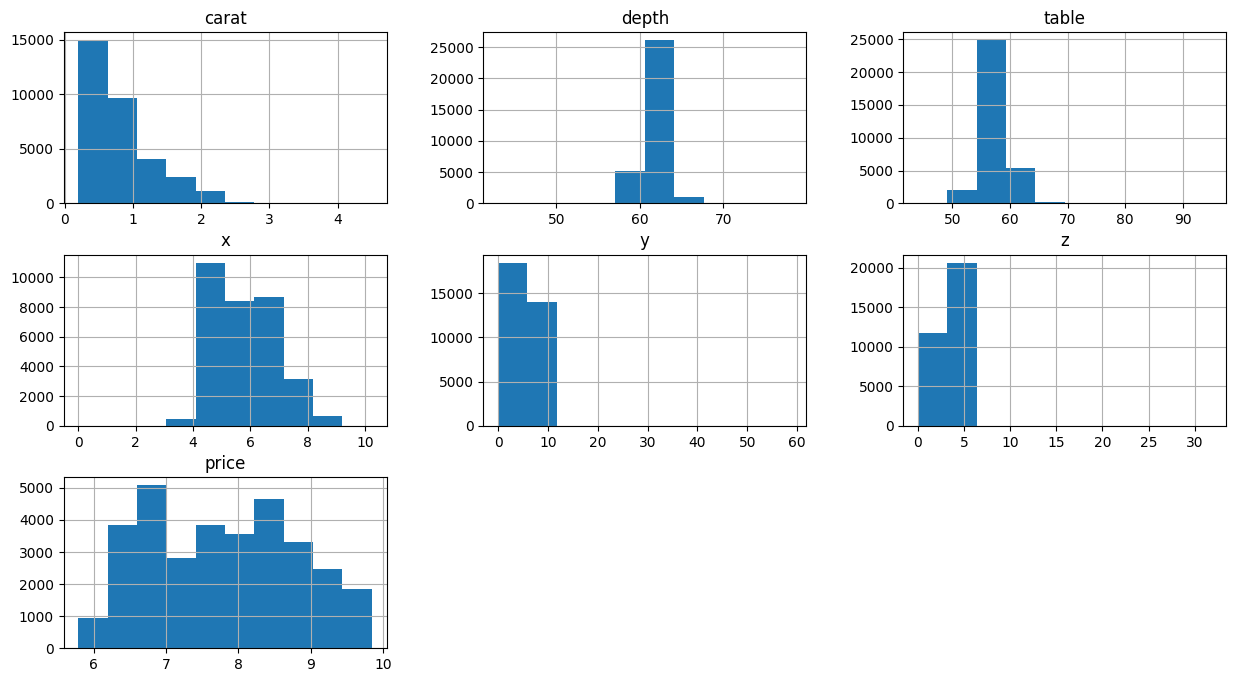

In [226]:
train_data.hist(figsize=(15,8))

In [227]:
train_data["depth"] = np.log(train_data["depth"] + 1)
train_data["table"] = np.log(train_data["table"] + 1)
train_data["x"] = np.log(train_data["x"] + 1)
train_data["y"] = np.log(train_data["y"] + 1)
train_data["z"] = np.log(train_data["z"] + 1)

array([[<AxesSubplot: title={'center': 'carat'}>,
        <AxesSubplot: title={'center': 'depth'}>,
        <AxesSubplot: title={'center': 'table'}>],
       [<AxesSubplot: title={'center': 'x'}>,
        <AxesSubplot: title={'center': 'y'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 'price'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

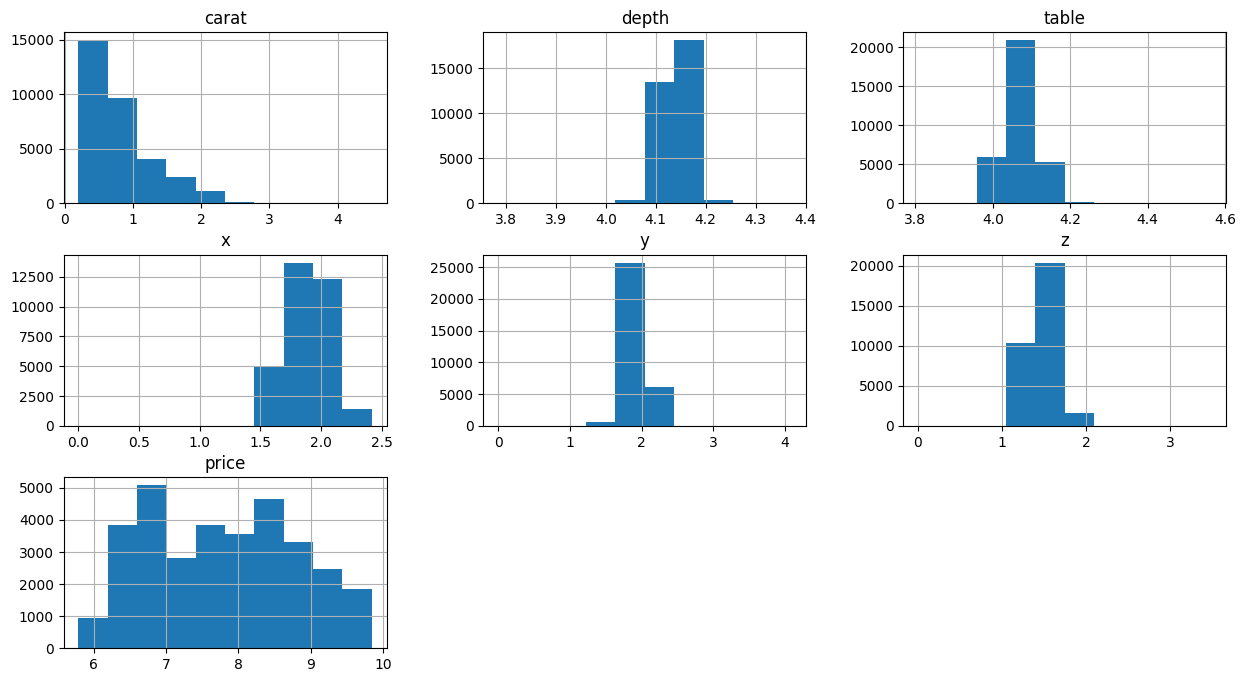

In [228]:
train_data.hist(figsize=(15,8))

## 2.1 One Hot Encoding + Normalization

In [229]:
from sklearn.preprocessing import MinMaxScaler

In [230]:
train_data = pd.get_dummies(data=train_data, drop_first=True)

In [231]:
train_data[:5]

,carat,depth,table,x,y,z,price,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
id,,,,,,,,,,,,,,,,,,,,,
28665,0.33,4.115780,4.077537,1.708378,1.704748,1.313724,6.681,0,0,1,...,0,0,0,0,0,0,1,0,0,0
37184,0.36,4.115780,4.094345,1.719189,1.729884,1.329724,6.671,0,0,1,...,0,0,0,0,0,0,0,1,0,0
29652,0.90,4.102643,4.060443,1.972691,1.993339,1.553925,8.394,0,0,0,...,0,0,0,0,1,0,0,0,0,0
11755,1.12,4.122284,4.127134,2.042518,2.033398,1.619388,8.091,0,0,1,...,0,0,1,0,0,1,0,0,0,0
6368,0.73,4.125520,4.060443,1.918392,1.924249,1.515127,8.036,0,1,0,...,0,0,0,0,1,0,0,0,0,0


<AxesSubplot: >

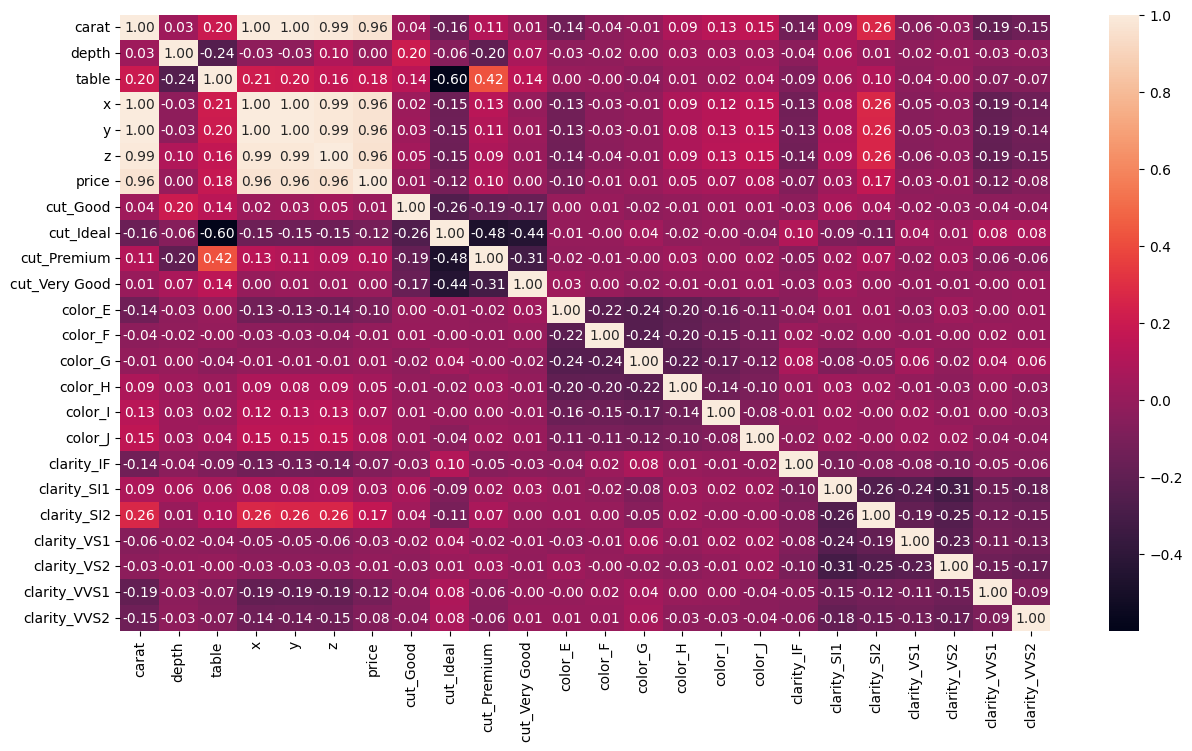

In [232]:
plt.figure(figsize=(15,8))
sns.heatmap(train_data.corr(method='spearman'), annot=True, fmt=".2f")

In [233]:
train_data["price_carat"] = train_data["price"]/train_data["carat"]

<AxesSubplot: >

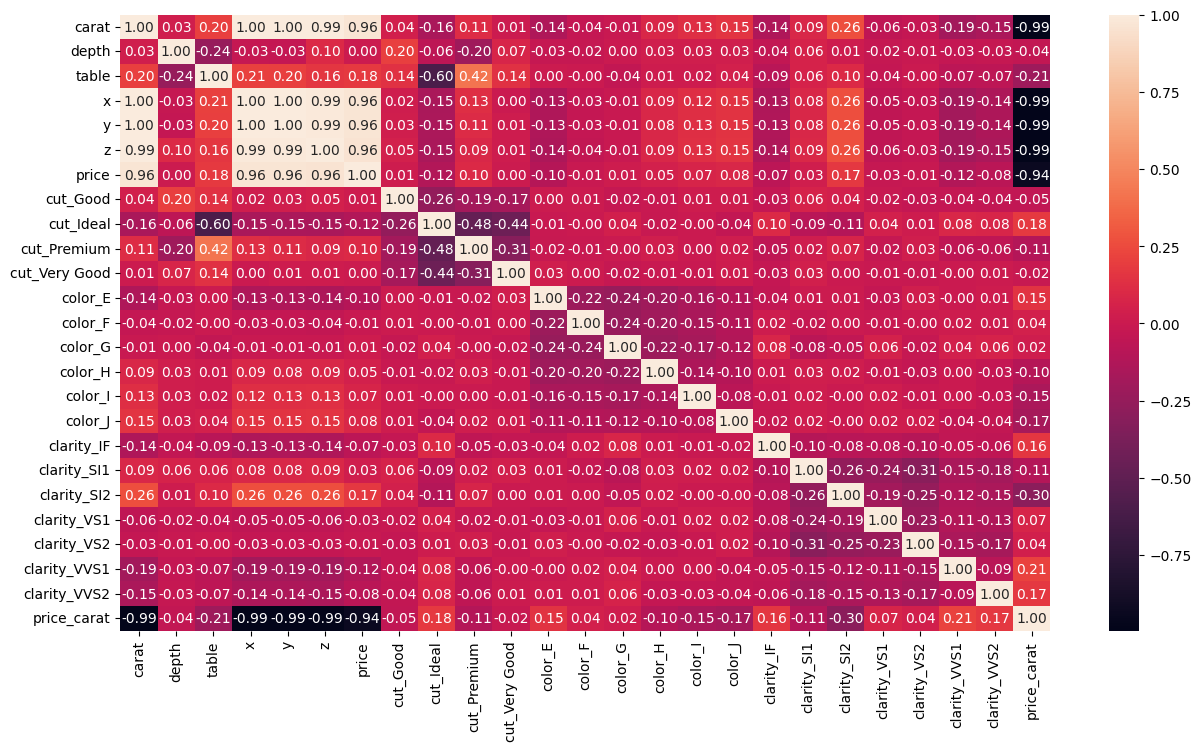

In [234]:
plt.figure(figsize=(15,8))
sns.heatmap(train_data.corr(method='spearman'), annot=True, fmt=".2f")

In [235]:
train_data.drop(columns=["x", "y", "z", "price_carat"], inplace=True)

<AxesSubplot: >

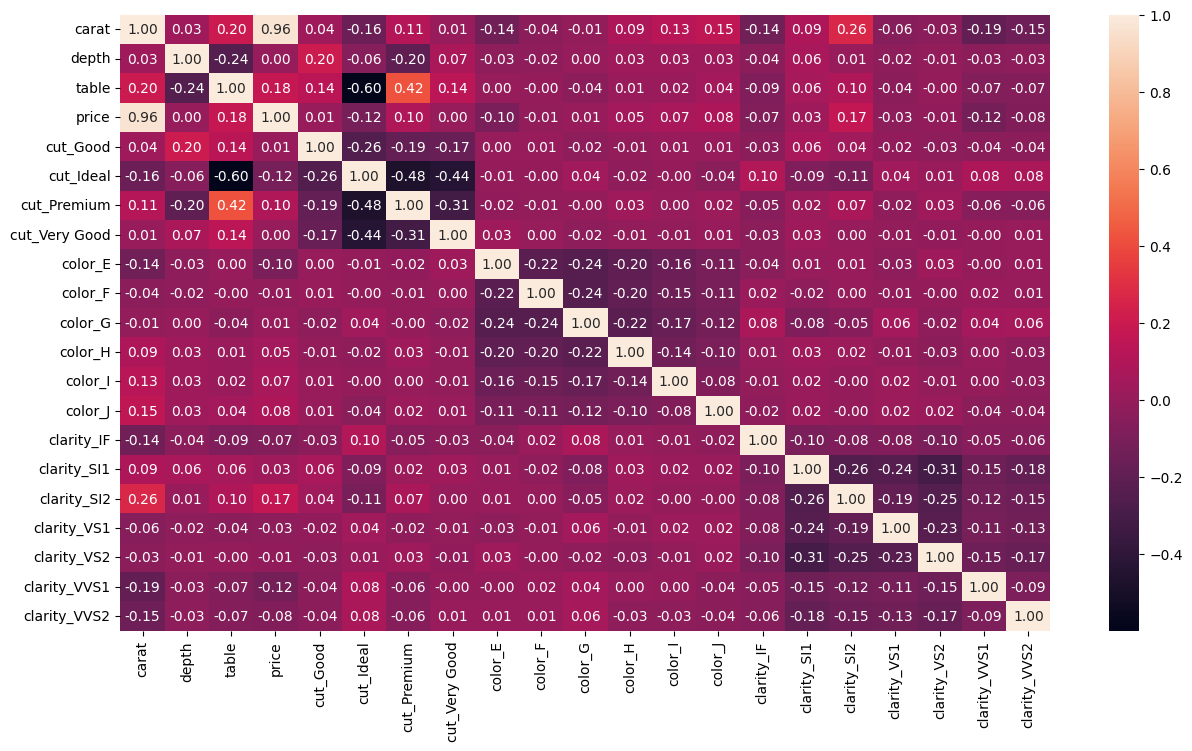

In [236]:
plt.figure(figsize=(15,8))
sns.heatmap(train_data.corr(method='spearman'), annot=True, fmt=".2f")

In [237]:
x_train, y_train = train_data.drop(columns=("price")), train_data["price"]
x_train[:5]

,carat,depth,table,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
id,,,,,,,,,,,,,,,,,,,,
28665,0.33,4.115780,4.077537,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
37184,0.36,4.115780,4.094345,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
29652,0.90,4.102643,4.060443,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
11755,1.12,4.122284,4.127134,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
6368,0.73,4.125520,4.060443,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [238]:
min_max_Scaler = MinMaxScaler()

x_train_s = min_max_Scaler.fit_transform(x_train)
x_train_s = pd.DataFrame(x_train_s, columns=x_train.columns)
x_train_s.set_index(keys=x_train.index, inplace=True)

In [239]:
min_max_Scaler.data_max_

array([4.5       , 4.3719763 , 4.56434819, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

## 2.2 Removing outliers

In [240]:
import eif as iso

In [241]:
train_data = x_train_s.join(y_train)
train_data[:5]

,carat,depth,table,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,...,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,price
id,,,,,,,,,,,,,,,,,,,,,
28665,0.030233,0.564134,0.357503,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.681
37184,0.037209,0.564134,0.379685,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.671
29652,0.162791,0.541785,0.334942,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.394
11755,0.213953,0.575199,0.422962,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.091
6368,0.123256,0.580705,0.334942,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.036


In [242]:
X = train_data[["carat", "depth", "table", "price"]]
X[:5]

,carat,depth,table,price
id,,,,
28665,0.030233,0.564134,0.357503,6.681
37184,0.037209,0.564134,0.379685,6.671
29652,0.162791,0.541785,0.334942,8.394
11755,0.213953,0.575199,0.422962,8.091
6368,0.123256,0.580705,0.334942,8.036


In [243]:
column_eif = iso.iForest(
    X.values, ntrees=500, sample_size=256, ExtensionLevel=1)

In [244]:
S1 = column_eif.compute_paths(X_in = X.values)

In [245]:
indexes_eif = np.argsort(S1)[-int(len(S1) * 0.05):]

train_data.reset_index(inplace=True)
train_data[:5]

,id,carat,depth,table,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,...,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,price
0,28665,0.030233,0.564134,0.357503,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.681
1,37184,0.037209,0.564134,0.379685,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.671
2,29652,0.162791,0.541785,0.334942,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.394
3,11755,0.213953,0.575199,0.422962,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.091
4,6368,0.123256,0.580705,0.334942,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.036


In [246]:
train_data.drop(index=indexes_eif, inplace=True)

array([[<AxesSubplot: title={'center': 'id'}>,
        <AxesSubplot: title={'center': 'carat'}>,
        <AxesSubplot: title={'center': 'depth'}>,
        <AxesSubplot: title={'center': 'table'}>,
        <AxesSubplot: title={'center': 'cut_Good'}>],
       [<AxesSubplot: title={'center': 'cut_Ideal'}>,
        <AxesSubplot: title={'center': 'cut_Premium'}>,
        <AxesSubplot: title={'center': 'cut_Very Good'}>,
        <AxesSubplot: title={'center': 'color_E'}>,
        <AxesSubplot: title={'center': 'color_F'}>],
       [<AxesSubplot: title={'center': 'color_G'}>,
        <AxesSubplot: title={'center': 'color_H'}>,
        <AxesSubplot: title={'center': 'color_I'}>,
        <AxesSubplot: title={'center': 'color_J'}>,
        <AxesSubplot: title={'center': 'clarity_IF'}>],
       [<AxesSubplot: title={'center': 'clarity_SI1'}>,
        <AxesSubplot: title={'center': 'clarity_SI2'}>,
        <AxesSubplot: title={'center': 'clarity_VS1'}>,
        <AxesSubplot: title={'center': 'clar

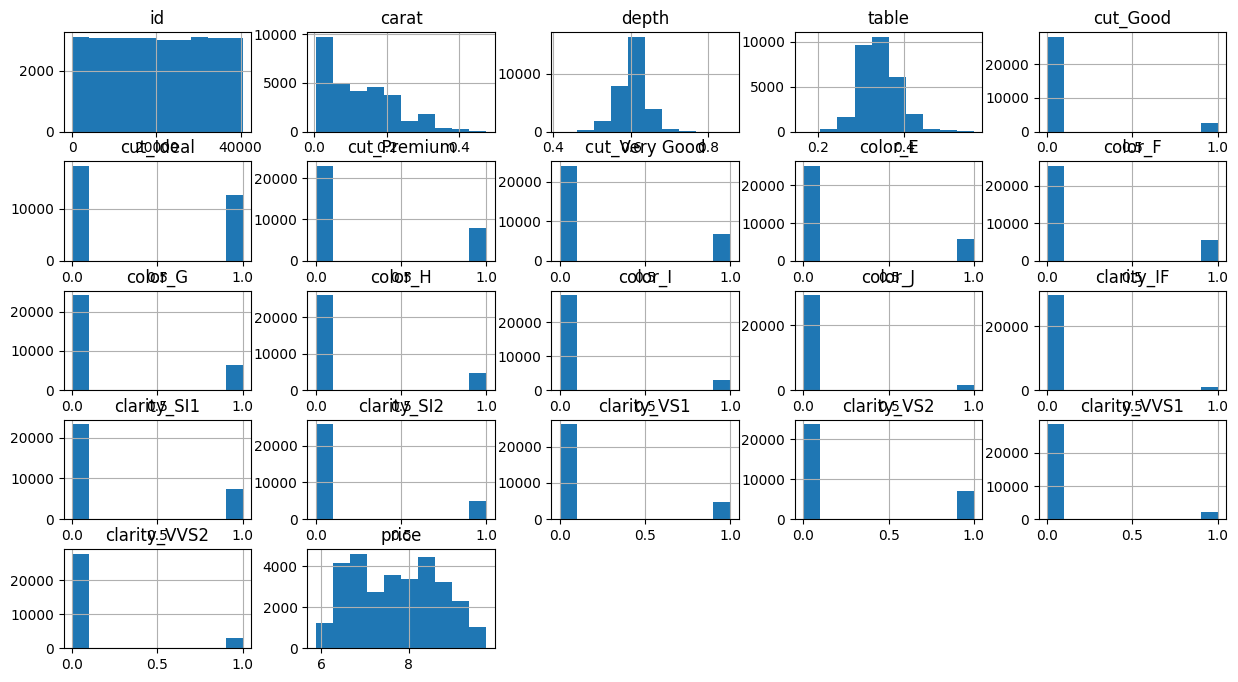

In [247]:
train_data.hist(figsize=(15,8))

In [248]:
train_data.set_index(train_data["id"], inplace=True)
train_data.drop(columns=("id"), inplace=True)

In [249]:
train_data[:5]

,carat,depth,table,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,...,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,price
id,,,,,,,,,,,,,,,,,,,,,
28665,0.030233,0.564134,0.357503,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.681
37184,0.037209,0.564134,0.379685,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.671
29652,0.162791,0.541785,0.334942,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.394
11755,0.213953,0.575199,0.422962,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.091
6368,0.123256,0.580705,0.334942,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.036


In [250]:
x_train_s, y_train = train_data.drop(columns=("price")), train_data["price"]

# 3. Comperison baseline-models

In [251]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [252]:
x_test = pd.get_dummies(x_test, drop_first=True)

x_test.drop(columns=["x", "y", "z"], inplace=True)
x_test.describe()

,carat,depth,table,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
count,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.00000,8091.000000,8091.000000
mean,0.800140,61.737783,57.432518,0.091460,0.404400,0.253739,0.220986,0.182425,0.184897,0.204177,0.148560,0.103448,0.056483,0.031516,0.240143,0.166976,0.151403,0.23520,0.070819,0.090842
std,0.483273,1.446901,2.215441,0.288279,0.490806,0.435177,0.414937,0.386218,0.388238,0.403124,0.355676,0.304562,0.230865,0.174720,0.427197,0.372977,0.358463,0.42415,0.256539,0.287402
min,0.200000,43.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.700000,61.800000,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,1.040000,62.500000,59.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,5.010000,79.000000,73.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [253]:
x_test["carat"] = np.log(x_test["carat"] + 1)
x_test["depth"] = np.log(x_test["depth"] + 1)
x_test["table"] = np.log(x_test["table"] + 1)

In [255]:
x_test_s = min_max_Scaler.transform(x_test)

x_test_s = pd.DataFrame(x_test_s, index=x_test.index, columns=x_test.columns)
x_test_s.describe()

,carat,depth,table,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
count,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.00000,8091.000000,8091.000000
mean,0.082690,0.603119,0.343813,0.091460,0.404400,0.253739,0.220986,0.182425,0.184897,0.204177,0.148560,0.103448,0.056483,0.031516,0.240143,0.166976,0.151403,0.23520,0.070819,0.090842
std,0.057776,0.039572,0.049491,0.288279,0.490806,0.435177,0.414937,0.386218,0.388238,0.403124,0.355676,0.304562,0.230865,0.174720,0.427197,0.372977,0.358463,0.42415,0.256539,0.287402
min,-0.004111,0.000000,0.139056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.031738,0.583451,0.311988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.076890,0.605263,0.334942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.119291,0.624121,0.379685,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,0.370564,1.017099,0.656476,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [259]:
y_train.values

array([6.681, 6.671, 8.394, ..., 7.5  , 8.61 , 9.346])

In [256]:
regression = LinearRegression()
regression.fit(x_train, y_train.values)

ValueError: Found input variables with inconsistent numbers of samples: [32364, 30746]

In [43]:
y_pred = regression.predict(x_test_s.values)
y_pred[:5]

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


array([ 6.38090579,  8.5637603 , 10.00285957,  7.61224359,  9.39065015])

In [44]:
mean_squared_error(Y_test.values, y_pred)

2.479634469054297

In [45]:
poly_2 = PolynomialFeatures(degree=2)
X_poly_2 = poly_2.fit_transform(X_train.values)
poly_2.fit(X_poly_2, Y_train.values)
regression_2 = LinearRegression()
regression_2.fit(X_poly_2, Y_train.values)

LinearRegression()

In [46]:
y_pred = regression_2.predict(poly_2.fit_transform(X_test_scaled.values))
y_pred[:5]

array([6.23484536, 8.69801064, 9.54026528, 7.77144356, 8.96850499])

In [47]:
mean_squared_error(Y_test.values, y_pred)

2.3323552369012117